### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
import warnings

%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
376,PSID192,0,23,13,0,0,0,0,601.4949,1394.6610,4975.505
80,NSW81,1,25,12,1,0,0,0,0.0000,0.0000,0.000
565,PSID381,0,21,13,1,0,0,0,0.0000,0.0000,17941.080
361,PSID177,0,19,11,0,0,0,1,0.0000,1693.6450,9853.481
245,PSID61,0,35,7,0,0,1,1,10715.2300,6087.0970,15177.730
395,PSID211,0,20,12,0,0,0,0,0.0000,1147.5970,15554.550
433,PSID249,0,19,3,0,0,1,1,0.0000,537.0968,0.000
115,NSW116,1,21,12,0,0,0,0,3670.8720,334.0494,12558.020
146,NSW147,1,19,8,1,0,0,1,0.0000,2657.0570,9970.681
153,NSW154,1,23,12,1,0,0,0,6269.3410,3039.9600,8484.239


In [3]:
df['white']=1-df['black']-df['hispan']
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
20,NSW21,1,23,11,1,0,0,1,0.000,0.0000,0.000,0
303,PSID119,0,42,7,0,0,1,1,4324.102,3457.1130,9856.436,1
26,NSW27,1,25,11,1,0,0,1,0.000,0.0000,9897.049,0
409,PSID225,0,18,8,0,1,0,1,0.000,902.3226,1306.310,0
581,PSID397,0,16,9,0,0,0,1,0.000,0.0000,6494.608,1
39,NSW40,1,24,10,1,0,0,1,0.000,0.0000,0.000,0
509,PSID325,0,18,10,0,0,0,1,3360.143,0.0000,0.000,1
444,PSID260,0,24,12,1,0,1,0,4232.016,320.4677,1273.800,0
144,NSW145,1,31,12,0,0,0,0,0.000,2611.2180,2484.549,1
219,PSID35,0,26,12,0,0,1,0,2345.242,7565.9030,2838.713,1


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(-8.700000000000003, 0.5, 're78')

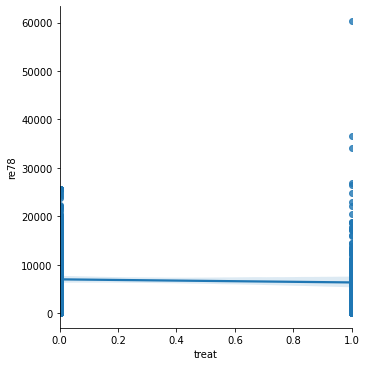

In [4]:
''' your code and explanations ''';
import seaborn as sn

re78_treat= df[['re78','treat']]
sn.lmplot('treat','re78', data=re78_treat)
plt.xlabel("treat")
plt.ylabel("re78")
# we can not see much difference between the two groups. There are several outliers in the treat 1 group, 
# and the treat 1 group seems to have more larger outcome salary than treat 0 group. Only comparing the 
# two variables does not work good to verify the correlation to

In [5]:
#答案方法，确实要比我的明确很多
treated = df.loc[df['treat'] == 1] #People that attained the programme
control = df.loc[df['treat'] == 0] 
treated.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [6]:
control.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


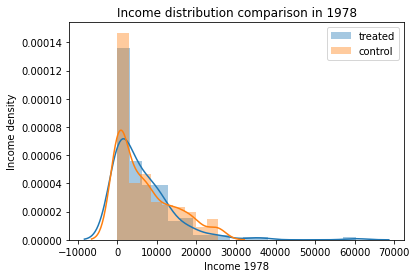

In [7]:
ax = sns.distplot(treated['re78'], hist=True, label='treated');
ax = sns.distplot(control['re78'], hist=True, label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

The treated group has:

lower mean earnings value

higher first (25%) percentile - low income interval (though)

Some outliers of really high income rates - with maximum income

The control group has:

higher mean earnings value

higher percentile (50%,75%)

higher number of people with income in the interval 12000 - 27000

We conclude that, in general, the control group outperforms the treated one in most of the cases.


## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(9.924999999999997, 0.5, 'age')

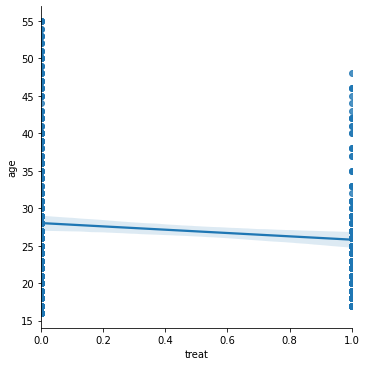

In [8]:
''' your code and explanations ''';
sn.lmplot('treat','age', data=df)
plt.xlabel("treat")
plt.ylabel("age")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.29999999999999716, 0.5, 'educ')

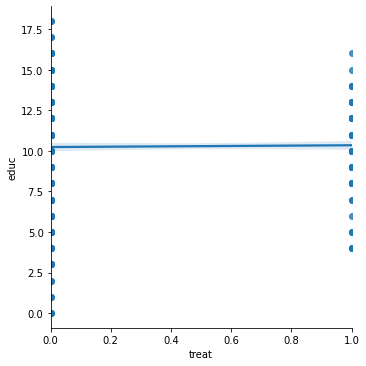

In [9]:
sn.lmplot('treat','educ', data=df)
plt.xlabel("treat")
plt.ylabel("educ")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(6.799999999999997, 0.5, 'black')

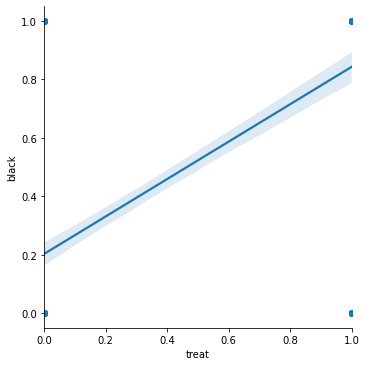

In [10]:
sn.lmplot('treat','black', data=df)
plt.xlabel("treat")
plt.ylabel("black")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(6.799999999999997, 0.5, 'hispan')

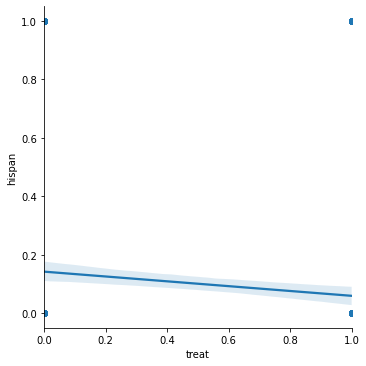

In [11]:
sn.lmplot('treat','hispan', data=df)
plt.xlabel("treat")
plt.ylabel("hispan")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(6.799999999999997, 0.5, 'married')

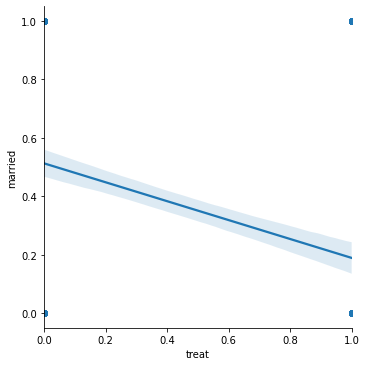

In [12]:
sn.lmplot('treat','married', data=df)
plt.xlabel("treat")
plt.ylabel("married")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(6.799999999999997, 0.5, 'nodegree')

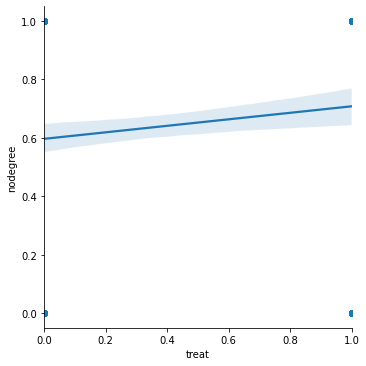

In [13]:
sn.lmplot('treat','nodegree', data=df)
plt.xlabel("treat")
plt.ylabel("nodegree")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(-8.825000000000003, 0.5, 're74')

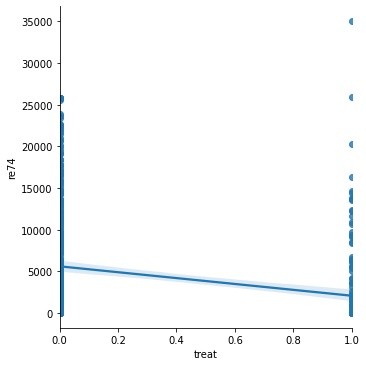

In [14]:
sn.lmplot('treat','re74', data=df)
plt.xlabel("treat")
plt.ylabel("re74")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(-8.825000000000003, 0.5, 're75')

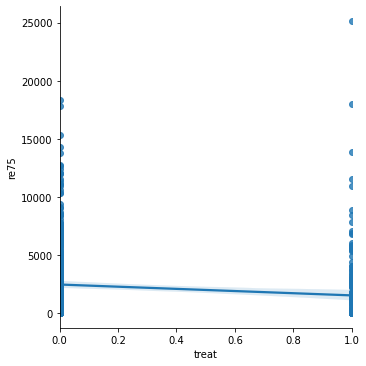

In [15]:
sn.lmplot('treat','re75', data=df)
plt.xlabel("treat")
plt.ylabel("re75")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(6.799999999999997, 0.5, 'white')

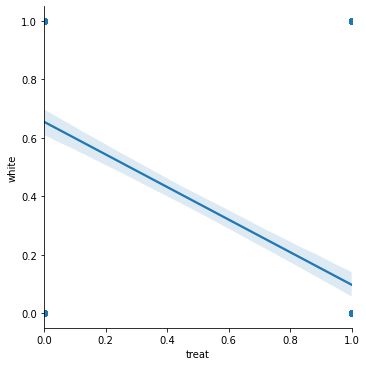

In [16]:
sn.lmplot('treat','white', data=df)
plt.xlabel("treat")
plt.ylabel("white")

#In treated and untreated group, there are many other variances which could influence the outcome salary, like race,
# education, and original salary. We can see there are some imbalance in the treat and untreated group among those 
#parameters.

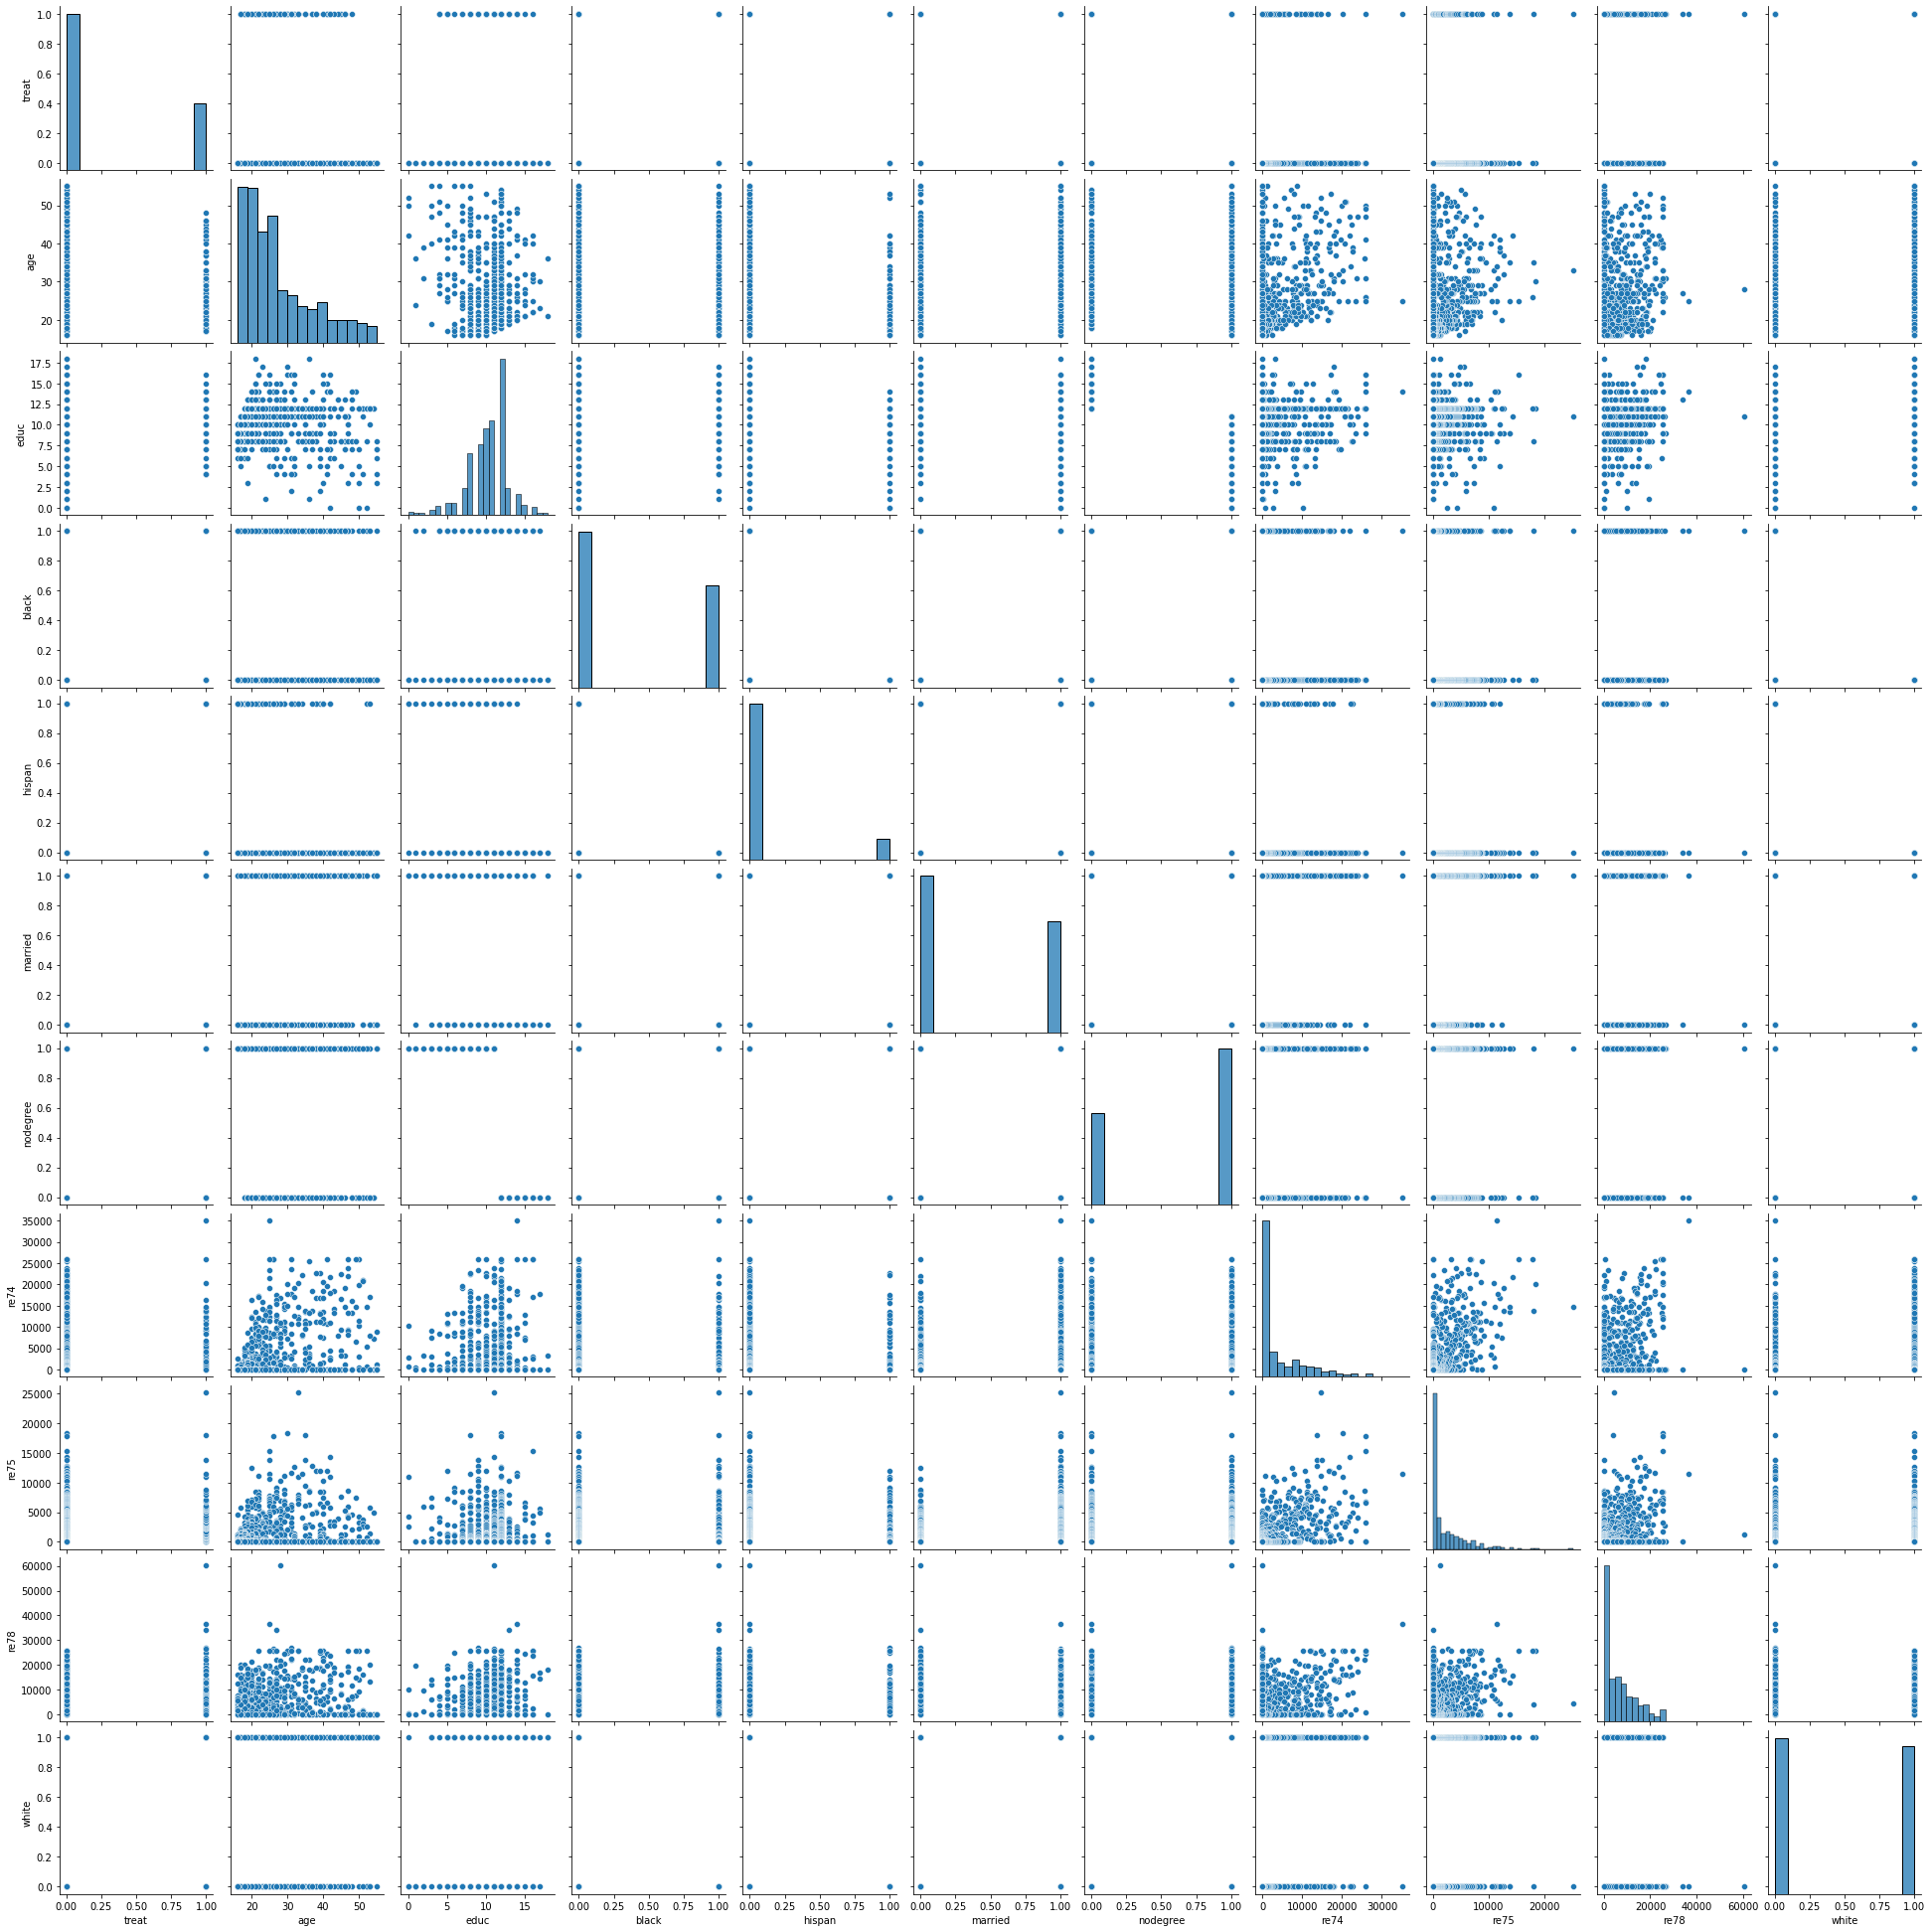

In [17]:
#答案的方法，没有什么要改的，就是学习就好了，答案的方法更好一些
sns.pairplot(df)

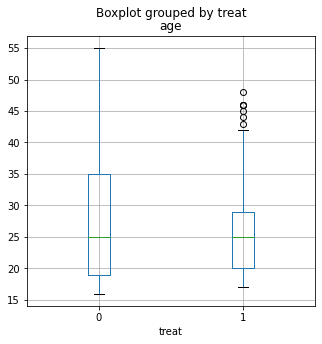

In [18]:
# Age -- quite different, the members of the treated tend
# to be younger than the ones in the control group
df.boxplot(by='treat', column='age', figsize = [5, 5], grid=True)
plt.show()

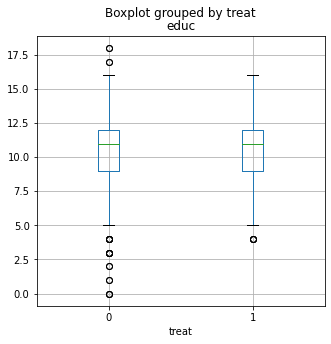

In [19]:
# education
df.boxplot(by='treat', column='educ', figsize = [5, 5], grid=True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


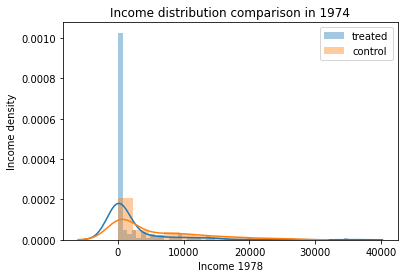

In [20]:
# income in the previous year

ax = sns.distplot(treated['re74'], hist=True, label='treated');
ax = sns.distplot(control['re74'], hist=True, label='control')
ax.set(title='Income distribution comparison in 1974',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

# As we can observe from this plot, the number of treated 
# members that were unemployed before the training program is
# quite high. So this might give us an intuition of how much the
# program helped people to find a job, independently of the income 
# that they got eventually.

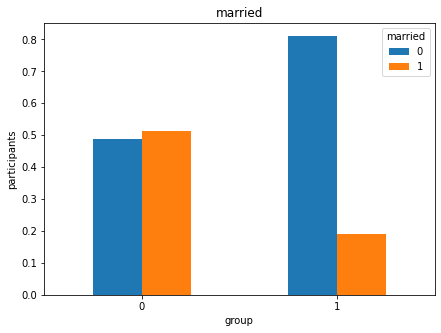

In [21]:
# marriage

group = df.groupby(['treat', 'married'])['married'].count()
group = group.unstack()
group = group.div(group.sum(axis=1), axis=0)
pl = group.plot(kind='bar', figsize=[7,5], rot=0)
pl.set_title('married')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()

# The percentage of unmarried people between 
# the treated group is much higher than the married ones whereas
# in the control group, the two categories are balanced. This might
# be an indication of what type of people are included in 
# the program.

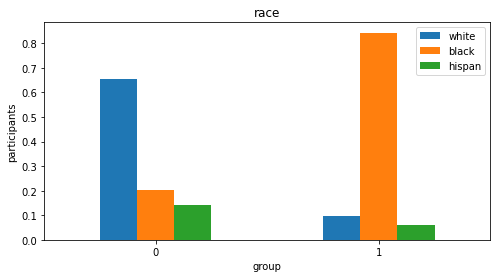

In [27]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

data_group = df.groupby(df.treat)['white', 'black', 'hispan'].sum()
data_group = data_group.div(data_group.sum(axis=1), axis=0)
pl = data_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('race')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()

# white outnumber the other races in the control group, and on the 
# other hand, in the treated group the proportion of black is almost 
# the only one

In [23]:
#要使用多种plot

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [31]:
''' your code and explanations ''';
# let's standardize the continuous features
df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
df['educ'] = (df['educ'] - df['educ'].mean())/df['educ'].std()
df['re74'] = (df['re74'] - df['re74'].mean())/df['re74'].std()
df['re75'] = (df['re75'] - df['re75'].mean())/df['re75'].std()
mod = smf.logit(formula='treat ~  age + educ + C(black) + C(hispan)+C(white)  + C(married) + C(nodegree) + +re74 + re75', data=df)
res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 21
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sun, 08 Nov 2020   Pseudo R-squ.:                  0.3508
Time:                        12:07:17   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.1259        nan        nan        nan         nan         nan
C(black)[T

In [32]:
df

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,Propensity_score
0,NSW1,1,0.975268,0.278227,1,0,1,1,-0.703546,-0.662971,9930.0460,0,0.638770
1,NSW2,1,-0.542768,-0.482714,0,1,0,1,-0.703546,-0.662971,3595.8940,0,0.224634
2,NSW3,1,0.266851,0.658697,1,0,0,0,-0.703546,-0.662971,24909.4500,0,0.678244
3,NSW4,1,-0.036756,0.278227,1,0,0,1,-0.703546,-0.662971,7506.1460,0,0.776324
4,NSW5,1,0.570459,-0.863185,1,0,0,1,-0.703546,-0.662971,289.7899,0,0.701639
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,PSID425,0,-0.947578,0.278227,0,0,0,1,-0.703546,-0.662971,10150.5000,1,0.123144
610,PSID426,0,-0.340363,-3.526478,0,1,1,1,-0.703546,-0.662971,19464.6100,0,0.034560
611,PSID427,0,-0.643970,2.941520,0,0,0,0,-0.703546,-0.662971,0.0000,1,0.183351
612,PSID428,0,0.469256,-2.004596,1,0,1,1,-0.703546,-0.662971,187.6713,0,0.383032


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

For this task, we implement the simplest, full optimal matching, and analyse the results.

In order to perform matching between pairs, a distance/similarity function is needed. Since the library used for the matching (networkx) has a function that maximizes the sum of weights between pairs, it is natural to use a function that measures similarity.

Wanting to minimize the difference of propensity scores between pairs, we define the similarity function between two instances $x$ and $y$ like:

$$ similarity(x,y) = 1 - | propensity\_score(x) - propensity\_score(y) |$$
This function captures the difference in scores like a distance, but since the distance defined like that would always be between 0 and 1, subtracting it from 1 would be a meaningful measure to use for similarity.

In [40]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [98]:
''' your code and explanations ''';
control_person=df.loc[df['treat'] == 1]
treated_person=df.loc[df['treat'] == 0]
# Create an empty undirected graph
G = nx.Graph()
# Loop through all the pairs of instances
for control_id, control_row in control_person.iterrows():
    for treatment_id, treatment_row in treated_person.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

In [100]:
matching = nx.max_weight_matching(G)
matching

{(0, 411),
 (1, 451),
 (2, 611),
 (4, 510),
 (10, 559),
 (11, 452),
 (17, 260),
 (18, 461),
 (24, 268),
 (25, 370),
 (26, 415),
 (27, 526),
 (32, 386),
 (33, 278),
 (35, 589),
 (38, 230),
 (40, 582),
 (41, 459),
 (42, 253),
 (43, 435),
 (45, 263),
 (48, 423),
 (49, 211),
 (50, 542),
 (51, 189),
 (52, 342),
 (56, 363),
 (59, 469),
 (64, 601),
 (65, 585),
 (68, 484),
 (70, 199),
 (72, 475),
 (73, 492),
 (79, 391),
 (80, 418),
 (81, 375),
 (83, 295),
 (88, 322),
 (90, 579),
 (91, 318),
 (92, 414),
 (94, 215),
 (96, 437),
 (98, 583),
 (99, 311),
 (104, 320),
 (105, 201),
 (106, 453),
 (109, 190),
 (112, 341),
 (113, 479),
 (114, 535),
 (115, 574),
 (116, 532),
 (117, 462),
 (120, 607),
 (121, 243),
 (122, 550),
 (128, 392),
 (129, 372),
 (130, 343),
 (131, 367),
 (133, 422),
 (136, 293),
 (137, 523),
 (138, 477),
 (139, 279),
 (144, 340),
 (145, 514),
 (146, 539),
 (148, 540),
 (152, 557),
 (153, 284),
 (154, 519),
 (156, 551),
 (158, 558),
 (160, 565),
 (161, 575),
 (162, 563),
 (163, 518

In [102]:
for t in matching:
    print(t)
    print("/n")

(383, 103)
/n
(98, 583)
/n
(90, 579)
/n
(424, 58)
/n
(408, 16)
/n
(588, 102)
/n
(465, 22)
/n
(164, 366)
/n
(72, 475)
/n
(25, 370)
/n
(73, 492)
/n
(1, 451)
/n
(450, 61)
/n
(177, 302)
/n
(120, 607)
/n
(83, 295)
/n
(387, 151)
/n
(169, 511)
/n
(600, 5)
/n
(555, 37)
/n
(334, 142)
/n
(456, 21)
/n
(294, 14)
/n
(176, 608)
/n
(572, 71)
/n
(162, 563)
/n
(94, 215)
/n
(64, 601)
/n
(593, 57)
/n
(104, 320)
/n
(33, 278)
/n
(590, 30)
/n
(40, 582)
/n
(42, 253)
/n
(402, 77)
/n
(96, 437)
/n
(528, 9)
/n
(131, 367)
/n
(275, 12)
/n
(10, 559)
/n
(412, 127)
/n
(261, 86)
/n
(324, 69)
/n
(173, 455)
/n
(163, 518)
/n
(24, 268)
/n
(573, 62)
/n
(369, 3)
/n
(283, 119)
/n
(158, 558)
/n
(139, 279)
/n
(45, 263)
/n
(161, 575)
/n
(117, 462)
/n
(129, 372)
/n
(68, 484)
/n
(444, 118)
/n
(156, 551)
/n
(584, 28)
/n
(538, 125)
/n
(507, 174)
/n
(541, 87)
/n
(92, 414)
/n
(130, 343)
/n
(148, 540)
/n
(345, 66)
/n
(474, 134)
/n
(357, 159)
/n
(51, 189)
/n
(595, 143)
/n
(449, 13)
/n
(232, 36)
/n
(32, 386)
/n
(11, 452)
/n
(571, 60)
/n

In [89]:
for t in matching:
    for subj_id in t:
        print(subj_id)

383
103
98
583
90
579
424
58
408
16
588
102
465
22
164
366
72
475
25
370
73
492
1
451
450
61
177
302
120
607
83
295
387
151
169
511
600
5
555
37
334
142
456
21
294
14
176
608
572
71
162
563
94
215
64
601
593
57
104
320
33
278
590
30
40
582
42
253
402
77
96
437
528
9
131
367
275
12
10
559
412
127
261
86
324
69
173
455
163
518
24
268
573
62
369
3
283
119
158
558
139
279
45
263
161
575
117
462
129
372
68
484
444
118
156
551
584
28
538
125
507
174
541
87
92
414
130
343
148
540
345
66
474
134
357
159
51
189
595
143
449
13
232
36
32
386
11
452
571
60
79
391
138
477
473
171
521
132
17
260
250
44
425
54
217
123
410
108
348
78
109
190
106
453
603
167
0
411
529
19
344
74
38
230
513
75
556
55
48
423
545
82
576
97
282
126
80
418
56
363
517
157
192
89
208
140
50
542
525
149
604
15
145
514
18
461
596
20
515
150
612
101
401
110
114
535
2
611
273
180
41
459
568
168
466
111
389
175
594
31
154
519
35
589
361
39
442
147
26
415
564
182
393
172
122
550
99
311
354
183
368
8
178
549
404
181
170
371
546
179
5

In [114]:
balanced_df_1 = df.iloc[[subj_id for t in matching for subj_id in t]]
balanced_df_1

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,Propensity_score
383,PSID199,0,0.165649,-0.102244,0,1,0,1,-0.127377,-0.261521,6694.101,0,0.237886
103,NSW104,1,-0.947578,0.278227,1,0,0,1,-0.703546,-0.662971,4814.627,0,0.750705
98,NSW99,1,-0.239161,-0.102244,1,0,0,1,-0.703546,-0.662971,0.000,0,0.741065
583,PSID399,0,-0.036756,1.419638,1,0,0,0,-0.703546,-0.662971,10122.430,0,0.735166
90,NSW91,1,0.368054,0.278227,1,0,1,1,-0.703546,-0.662971,14509.930,0,0.616653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,NSW7,1,-0.441566,0.658697,1,0,0,0,-0.703546,-0.662971,0.000,0,0.653684
81,NSW82,1,-0.947578,0.658697,1,0,0,0,-0.703546,-0.662971,2321.107,0,0.635616
375,PSID191,0,-0.947578,0.658697,1,0,0,0,-0.459771,-0.235446,3057.416,0,0.626761
133,NSW134,1,-0.745173,0.278227,1,0,0,1,1.815551,-0.212382,6943.342,0,0.510499


In [96]:
#race is not balanced. we will include this additional explicit requirement in task 5


## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [116]:
''' your code and explanations ''';
treatment_df = df[df['treat'] == 1]
control_df = df[df['treat'] == 0]


G_1 = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():
        # Adds an edge only if the individuals have the same race
        if (control_row['black'] == treatment_row['black'])and (control_row['hispan'] == treatment_row['hispan']):
            similarity = get_similarity(control_row['Propensity_score'],treatment_row['Propensity_score'])
            G_1.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching_1 = nx.max_weight_matching(G_1)

In [117]:
for t in matching_1:
    print(t)

(556, 77)
(361, 75)
(302, 7)
(225, 114)
(1, 250)
(145, 371)
(120, 415)
(401, 13)
(515, 126)
(21, 311)
(169, 529)
(294, 14)
(280, 125)
(184, 600)
(584, 70)
(592, 19)
(232, 48)
(539, 47)
(11, 565)
(161, 189)
(32, 343)
(278, 127)
(211, 37)
(24, 595)
(517, 119)
(528, 9)
(477, 183)
(552, 12)
(33, 570)
(17, 583)
(42, 582)
(324, 142)
(363, 100)
(525, 86)
(540, 141)
(104, 596)
(18, 590)
(174, 230)
(137, 318)
(155, 564)
(105, 380)
(128, 345)
(558, 103)
(171, 444)
(538, 109)
(41, 270)
(461, 69)
(43, 459)
(519, 31)
(453, 159)
(81, 571)
(144, 389)
(56, 514)
(0, 253)
(440, 76)
(410, 35)
(58, 462)
(217, 123)
(344, 172)
(124, 535)
(61, 357)
(208, 138)
(282, 151)
(402, 122)
(165, 414)
(82, 526)
(366, 22)
(275, 139)
(2, 554)
(475, 164)
(560, 46)
(146, 437)
(84, 373)
(568, 166)
(521, 54)
(192, 89)
(162, 612)
(484, 181)
(68, 492)
(67, 524)
(96, 450)
(283, 38)
(215, 111)
(112, 375)
(178, 549)
(59, 284)
(64, 243)
(107, 452)
(10, 510)
(360, 95)
(152, 557)
(180, 604)
(154, 603)
(576, 30)
(88, 322)
(52, 573)


In [118]:
balanced_df_2 = df.iloc[[subj_id for t in matching_1 for subj_id in t]]
balanced_df_2

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,Propensity_score
556,PSID372,0,-0.745173,-0.482714,1,0,0,1,-0.703546,-0.662971,6083.800,0,0.692390
77,NSW78,1,-0.643970,-0.482714,1,0,0,1,-0.703546,-0.662971,0.000,0,0.695740
361,PSID177,0,-0.846375,0.278227,0,0,0,1,-0.703546,-0.149072,9853.481,1,0.135089
75,NSW76,1,-0.239161,0.278227,0,0,0,1,-0.703546,-0.662971,18783.350,1,0.135574
302,PSID118,0,-0.745173,0.278227,1,0,0,1,-0.703546,0.393075,5495.665,0,0.789173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,PSID109,0,-0.643970,1.800109,0,0,1,0,0.369550,0.514216,0.000,1,0.043048
99,NSW100,1,0.368054,-0.482714,0,1,0,1,-0.703546,-0.662971,26817.600,0,0.250327
372,PSID188,0,-1.048780,-0.102244,0,1,0,1,-0.703546,-0.221865,6918.716,0,0.253744
133,NSW134,1,-0.745173,0.278227,1,0,0,1,1.815551,-0.212382,6943.342,0,0.510499


## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [121]:
''' your code and explanations ''';
treated = balanced_df_2.loc[balanced_df_2['treat'] == 1] #People that attained the program
control = balanced_df_2.loc[balanced_df_2['treat'] == 0] #People that didn't attain the program
treated.re78.describe()

count      116.000000
mean      6375.738003
std       6670.986821
min          0.000000
25%        758.102600
50%       4648.736000
75%      10160.440000
max      36646.950000
Name: re78, dtype: float64

In [122]:
control.re78.describe()

count      116.000000
mean      5095.456025
std       6047.014862
min          0.000000
25%          0.000000
50%       2256.488500
75%       8942.092750
max      20243.380000
Name: re78, dtype: float64

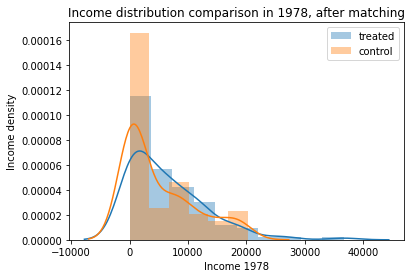

In [123]:
ax = sns.distplot(treated['re78'], hist=True, label='treated');
ax = sns.distplot(control['re78'], hist=True, label='control')
ax.set(title='Income distribution comparison in 1978, after matching',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()
# Final conclusion: after the propensity score matching, the results drastically change and support the 
# positive effect of the training program.